In [69]:
#In this notebook i copied pytorch documentation attention code
#and added logging for every step at training. The log part is appended to the end

In [ ]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('D:/data6/deu-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    print("len",len(lines))
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
lines = open('D:/data6/deu-eng/%s-%s.txt' % ("eng", "deu"), encoding='utf-8').\
        read().strip().split('\n')

In [7]:
lines[0]

'Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'deu', False)
print(random.choice(pairs))

Reading lines...
len 217032
Read 217032 sentence pairs
Trimmed to 11809 sentence pairs
Counting words...
Counted words:
eng 3129
deu 4896
['i m studying several languages .', 'ich lerne mehrere sprachen .', 'cc by . france attribution tatoeba .org ck yorwba ']


In [10]:
print(random.choice(pairs))

['i m not tired .', 'ich bin nicht mude .', 'cc by . france attribution tatoeba .org ck pfirsichbaeumchen ']


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




In [13]:
temp_map = {}
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    #input : decoder_input (input obtained at each step)    
    #hidden : decoder_hidden, value returned from this function is passed again
    #encoder_outputs : all outputs steps of encode,static in this function    
    def forward(self, input, hidden, encoder_outputs):
        temp_map["hidden_"] = hidden
        temp_map["input"] = input
        temp_map["encoder_outputs"] = encoder_outputs
        
        embedded = self.embedding(input).view(1, 1, -1)
        temp_map["embedded"] = embedded
        
        embedded = self.dropout(embedded)
        temp_map["embedded_dropout"] = embedded
        
        
        tensor_cat = torch.cat((embedded[0], hidden[0]), 1)
        temp_map["tensor_cat"] = tensor_cat
        
        attn_vector = self.attn(tensor_cat)
        temp_map["attn_vector"] = attn_vector
        
        #!!! attn weights are created without encoder data
        #so it means it is learned over time, we are creating these weights(by a linear layer)
        #and multiply with encoder outputs 
        #so over time(with backpropagation) we learn better attention
        #examle at 1st we   could be mapping to ich
        #but over time I will map to ich
        #so attention weights is learned over time
        attn_weights = F.softmax(attn_vector, dim=1)
        temp_map["attn_weights"] = attn_weights
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        temp_map["attn_applied"] = attn_applied

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        temp_map["output"] = output
        
        output = self.attn_combine(output).unsqueeze(0)
        temp_map["output attn_combine"] = output

        output = F.relu(output)
        temp_map["output relu"] = output
        
        output_step, hidden_step = self.gru(output, hidden)
        temp_map["output_step"] = output_step
        temp_map["hidden_step"] = hidden_step

        output_softmax = F.log_softmax(self.out(output_step[0]), dim=1)
        temp_map["output_softmax"] = output_softmax
        
        return output_softmax, hidden_step, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
import gc

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    gc.collect()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:
evaluate_queue = []

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        evaluate_queue.append(["input_tensor",input_tensor])
        evaluate_queue.append(["encoder_hidden",encoder_hidden])

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        evaluate_queue.append(["encoder_outputs",encoder_outputs])

        for ei in range(input_length):
            evaluate_queue.append(["input_tensor[ei]",input_tensor[ei]])
            evaluate_queue.append(["encoder_hidden",encoder_hidden])
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            evaluate_queue.append(["encoder_output",encoder_output])
            evaluate_queue.append(["encoder_hidden",encoder_hidden])
            
            encoder_outputs[ei] += encoder_output[0, 0]
            evaluate_queue.append(["encoder_outputs[ei]",encoder_outputs[ei]])

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        evaluate_queue.append(["decoder_input",decoder_input])

        decoder_hidden = encoder_hidden
        evaluate_queue.append(["decoder_hidden",decoder_hidden])

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            evaluate_queue.append(["decoder_output",decoder_output])
            evaluate_queue.append(["decoder_hidden",decoder_hidden])
            evaluate_queue.append(["decoder_attention",decoder_attention])
            
            
            decoder_attentions[di] = decoder_attention.data
            evaluate_queue.append(["decoder_attentions[di]",decoder_attentions[di]])
            
            topv, topi = decoder_output.data.topk(1)
            evaluate_queue.append(["topv",topv])
            evaluate_queue.append(["topi",topi])
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                evaluate_queue.append(["output_lang.index2word[topi.item()]",output_lang.index2word[topi.item()]])
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
            evaluate_queue.append(["decoder_input",decoder_input])

        evaluate_queue.append(["decoded_words",decoded_words])    
        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 1000, print_every=500)

In [67]:
print( encoder1)

EncoderRNN(
  (embedding): Embedding(3129, 256)
  (gru): GRU(256, 256)
)


In [68]:
print( attn_decoder1)

AttnDecoderRNN(
  (embedding): Embedding(4896, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=4896, bias=True)
)


2m 49s (- 2m 49s) (500 50%) 1.3836
4m 56s (- 0m 0s) (1000 100%) 1.4017


<Figure size 432x288 with 0 Axes>

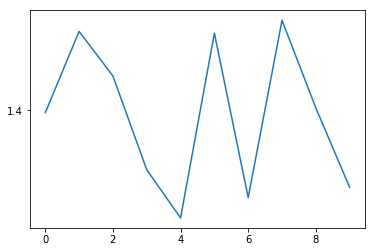

In [22]:
#1.3408
import os.path
decoder_path = "D:/data6/10iter_decoder"
encoder_path = "D:/data6/10iter_encoder"

for i in range(1):
    gc.collect()
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    
    if os.path.isfile(decoder_path) :
        encoder1.load_state_dict(torch.load(encoder_path))
        attn_decoder1.load_state_dict(torch.load(decoder_path))
        
    trainIters(encoder1, attn_decoder1, 1000, print_every=500)
    torch.save(attn_decoder1.state_dict(), decoder_path)
    torch.save(encoder1.state_dict(), encoder_path)
        

In [23]:
#torch.save(attn_decoder1.state_dict(), "D:/data6/10iter_decoder")
#torch.save(encoder1.state_dict(), "D:/data6/10iter_encoder")
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval() 3.2

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> you re stronger than us .
= du bist starker als wir .
< sie sind starker als wir . <EOS>

> he s an excellent brain surgeon .
= er ist ein gro artiger hirnchirurg .
< er ist ein guter er . . <EOS>

> i m so sorry .
= das tut mir sehr leid .
< es tut mir sehr leid . <EOS>

> he is a fast runner .
= er ist ein schneller laufer .
< er ist ein schneller laufer . <EOS>

> i am washing my brother s car .
= ich wasche den wagen meines bruders .
< ich interessiere mit meinem auto auto . <EOS>

> i m going to boston for thanksgiving .
= ich fahre zum erntedankfest nach boston .
< ich fahre nach boston nach boston . <EOS>

> he is always laughing .
= er lacht immer .
< er lacht immer . <EOS>

> he s buying an old hat .
= er kauft einen alten hut .
< er ist einen alten . . <EOS>

> we re a long way from home .
= wir sind fernab der heimat .
< wir sind von der hause . <EOS>

> he is a medical student .
= er ist medizinstudent .
< er ist student student . <EOS>



In [74]:

output_words, attentions = evaluate(encoder1, attn_decoder1, "i am brushing my teeth")
print(attentions.numpy().shape)
print(output_words)
print(attentions.numpy())


(6, 10)
['ich', 'tue', 'mein', 'an', '.', '<EOS>']
[[3.5155601e-06 9.9994254e-01 9.7708853e-06 4.1779476e-05 8.7276923e-09
  1.4442042e-09 5.3250083e-08 2.1113597e-06 2.2067022e-07 1.3475658e-07]
 [1.4700676e-06 2.9412363e-04 1.2592989e-05 9.9690753e-01 3.3379237e-08
  2.7584888e-03 6.3479993e-10 2.1748529e-05 6.5016316e-08 3.9088613e-06]
 [2.8746662e-04 2.5774317e-02 1.2194586e-03 3.4673192e-04 9.1602081e-01
  5.5792920e-02 2.1461681e-06 1.6593130e-04 2.6028344e-04 1.2982679e-04]
 [1.3434930e-05 2.4144172e-04 5.4845359e-06 1.4255546e-05 1.7102620e-02
  9.8260337e-01 9.5763575e-09 1.4521927e-05 3.3805375e-07 4.5601369e-06]
 [5.4318330e-04 2.4096256e-05 2.5761570e-04 7.4889149e-06 2.3950626e-04
  9.2479169e-01 1.1867065e-03 1.9699689e-04 4.8817170e-04 7.2264507e-02]
 [1.3949712e-02 3.9677344e-02 7.6107658e-03 2.5219308e-05 9.2762615e-09
  1.7558050e-01 4.9482751e-01 4.8227608e-03 7.8385789e-03 2.5566757e-01]]
[1, 3, 4, 5, 5, 6]


[1, 3, 4, 5, 5, 6]


<Figure size 432x288 with 0 Axes>

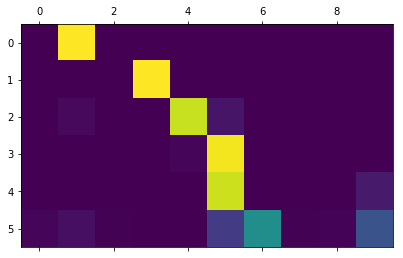

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [75]:
print("indexes of most important items in row matrix")
print([ np.argmax(nparr) for nparr in  attentions.numpy() ])
plt.matshow(attentions.numpy())
display(plt.figure())
plt.figure().show()

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)




input = you re not that old
output = das sind alt nicht . <EOS>


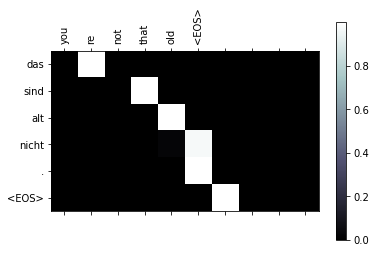

In [27]:
evaluateAndShowAttention("you re not that old")


input = i m buying fruit and chocolate .
output = ich bin gerade und und maria . <EOS>


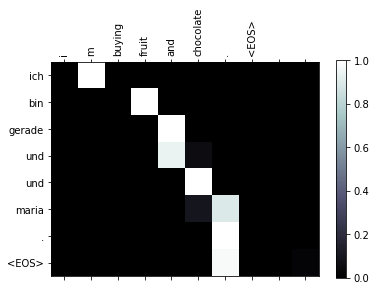

In [28]:
evaluateAndShowAttention("i m buying fruit and chocolate .")


input = i m a very careful driver .
output = ich bin ein sehr vorsichtiger fahrer . <EOS>


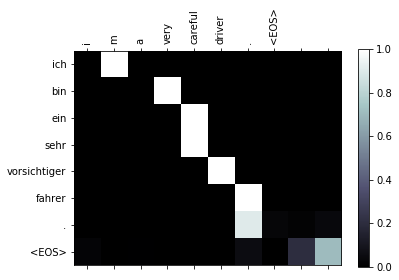

In [29]:
evaluateAndShowAttention("i m a very careful driver .")


In [30]:
def indexes_to_word(lang,indexes):
    return " ".join( [lang.index2word[i]  for i in torch.flatten(indexes).numpy() ] )

training_pairs = [tensorsFromPair(random.choice(pairs))for i in range(5000)]
iter = 1

training_pair = training_pairs[iter - 1]
input_tensor = training_pair[0]
target_tensor = training_pair[1]
print("input_tensor : ",indexes_to_word(input_lang,input_tensor) )
print("target_tensor : ",indexes_to_word(output_lang,target_tensor))

input_tensor :  i m closing the door . EOS
target_tensor :  ich mache die tur zu . EOS


In [31]:
input_length = input_tensor.size(0)
target_length = target_tensor.size(0)
print("input_length",input_length)
print("target_length",target_length)

input_length 7
target_length 7


In [32]:
encoder = encoder1
decoder = attn_decoder1
max_length=MAX_LENGTH
print("max_length :",max_length)

max_length : 10


In [33]:
print(attn_decoder1)

AttnDecoderRNN(
  (embedding): Embedding(4896, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=4896, bias=True)
)


In [34]:
encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
print("encoder_outputs",encoder_outputs.shape)

encoder_outputs torch.Size([10, 256])


In [35]:
encoder_hidden = encoder.initHidden()
print("encoder_outputs",encoder_hidden.shape)


encoder_outputs torch.Size([1, 1, 256])


In [36]:
for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        
        if ei == 0:
            print("encoder_hidden",encoder_hidden.shape)
            print("encoder_hidden",encoder_hidden)
            print("encoder_output",encoder_output.shape)
            print("encoder_output",encoder_output)
            
        encoder_outputs[ei] = encoder_output[0, 0]

encoder_hidden torch.Size([1, 1, 256])
encoder_hidden tensor([[[-0.1092,  0.6068,  0.6440,  0.1092,  0.1501,  0.6047, -0.8387,
          -0.8166, -0.0886, -0.1754,  0.7156, -0.7780,  0.1701,  0.0252,
           0.0283, -0.8889,  0.7755, -0.6490,  0.4626, -0.0189, -0.2753,
           0.1085,  0.8545,  0.0745, -0.7322,  0.5764,  0.2409, -0.7780,
           0.1100,  0.0108, -0.2655, -0.2258,  0.8253, -0.1568,  0.0476,
          -0.3258,  0.1139, -0.2597,  0.1731,  0.0390, -0.7949, -0.1106,
          -0.9918,  0.4892, -0.0011, -0.9184,  0.0561, -0.1848,  0.2176,
           0.8691,  0.5009,  0.1114,  0.9000,  0.0548,  0.1529, -0.2991,
          -0.4482, -0.1742,  0.0416,  0.8619,  0.8541,  0.8378, -0.9243,
          -0.3110,  0.4997,  0.0314, -0.4088,  0.7165, -0.8355,  0.2656,
          -0.7589,  0.4529, -0.9281, -0.6741, -0.0077, -0.8612,  0.3483,
          -0.1057, -0.5053,  0.9401,  0.7951, -0.1663, -0.3451,  0.8863,
          -0.1060,  0.8377, -0.9407,  0.8254,  0.0784,  0.8332, -0.303

In [37]:
#now we have encoder from all steps and we make 10 wors of 256 dim
print("encoder_output",encoder_outputs.shape)
print("encoder_output",encoder_outputs)

encoder_output torch.Size([10, 256])
encoder_output tensor([[-0.1092,  0.6068,  0.6440,  ...,  0.0129, -0.7997, -0.3886],
        [-0.8371,  0.6621,  0.5844,  ...,  0.9000, -0.9071, -0.4584],
        [-0.3424,  0.7598,  0.1242,  ...,  0.7139, -0.6456,  0.7970],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<CopySlices>)


In [38]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden

In [39]:
print("target_length",target_length)
for di in range(target_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)
    decoder_input = topi.squeeze().detach()  # detach from history as input
    if di == 0:
        print("decoder_output.shape",decoder_output.shape)
        print("decoder_output",decoder_output)
        print("decoder_hidden.shape",decoder_hidden.shape)
        print("decoder_hidden",decoder_hidden)
        print("decoder_attention.shape",decoder_attention.shape)
        print("decoder_attention",decoder_attention)
        
        print("topv",topv)
        print("topi",topi)
        
        print("loss decoder_output",decoder_output)
        print("loss decoder_output",np.argmax(decoder_output.detach().numpy()))
        print("loss target_tensor[di]",target_tensor[di])
        

    if decoder_input.item() == EOS_token:
                break

target_length 7
decoder_output.shape torch.Size([1, 4896])
decoder_output tensor([[-1.6563e+01, -1.5192e+01, -5.3444e-03,  ..., -1.6197e+01,
         -1.6191e+01, -1.5635e+01]], grad_fn=<LogSoftmaxBackward>)
decoder_hidden.shape torch.Size([1, 1, 256])
decoder_hidden tensor([[[-0.8016, -0.7724,  0.9238,  0.7037,  0.5894,  1.0000,  0.9223,
           0.9990,  0.7645,  0.9569, -0.1074, -0.3077,  0.9858, -0.5696,
           0.6748,  0.9833,  0.0442, -0.9999, -0.9983, -0.8694,  0.0173,
           0.9456,  0.9759, -0.6829, -0.2656, -0.9995,  0.9987,  0.9984,
           0.7189, -0.9469,  0.9875,  0.5727,  0.9672, -0.3181, -0.9997,
          -0.1843, -0.7806,  0.9936, -0.9996, -0.9716,  0.9808,  0.7352,
          -0.9904, -0.9927, -0.6990, -0.4892,  0.9596, -0.2970,  0.9999,
          -0.9401, -0.2684, -0.9877,  0.7597, -0.9900,  0.8922,  0.9995,
          -0.0862, -0.9576, -0.9538, -0.9986,  0.9969,  0.9616,  0.8432,
           0.9990, -0.6265, -0.5858, -0.9544, -0.9805,  0.9985, -0.9995,
  

In [40]:
#temp_map

In [41]:


def dump_step(step,dump_vector=True):
    print(" - ")
    print(step)
    
    print(temp_map[step].shape)
    if dump_vector:
        nplist = temp_map[step].flatten().detach().numpy()
        if np.ndim( nplist ) == 0:
            print(nplist)
        else:
            print( temp_map[step].flatten()[0:10] )
    

In [42]:
dump_step("input")

 - 
input
torch.Size([])
6


In [43]:
dump_step("encoder_outputs")

 - 
encoder_outputs
torch.Size([10, 256])
tensor([-0.1092,  0.6068,  0.6440,  0.1092,  0.1501,  0.6047, -0.8387, -0.8166,
        -0.0886, -0.1754], grad_fn=<SliceBackward>)


In [44]:
dump_step("hidden_")

 - 
hidden_
torch.Size([1, 1, 256])
tensor([-0.0854,  0.9885,  0.1168,  0.0655,  0.5957, -0.8884,  0.8772, -0.6210,
         0.2647,  0.9457], grad_fn=<SliceBackward>)


In [45]:
#embedded = self.embedding(input).view(1, 1, -1)
dump_step("embedded")    

 - 
embedded
torch.Size([1, 1, 256])
tensor([ 1.3873, -0.8388, -0.6731,  1.3380,  0.2238, -0.7001, -1.2516,  1.0845,
         0.5144, -0.7362], grad_fn=<SliceBackward>)


In [46]:
#drop out layes simply makes some layers 0
#dropout_p=0.1 so it makes 0 only this much item
#embedded = self.dropout(embedded)
dump_step("embedded_dropout",False)    
dropouted = temp_map["embedded_dropout"].flatten().detach().numpy()
print(np.where(dropouted == 0))
dropouted[np.where(dropouted == 0)]

 - 
embedded_dropout
torch.Size([1, 1, 256])
(array([ 41,  59,  66,  68,  76,  84,  89,  90,  92, 100, 154, 156, 158,
       161, 164, 184, 186, 187, 191, 196, 203, 204, 218, 229, 231, 239,
       255], dtype=int64),)


array([-0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,
       -0.], dtype=float32)

In [47]:
print(temp_map["embedded"][0].shape )
print(temp_map["hidden_"][0].shape )

torch.Size([1, 256])
torch.Size([1, 256])


In [48]:
#print(temp_map["embedded"][0] )
#print(temp_map["hidden_"][0])

In [49]:
dump_step("embedded") 
dump_step("hidden_") 


 - 
embedded
torch.Size([1, 1, 256])
tensor([ 1.3873, -0.8388, -0.6731,  1.3380,  0.2238, -0.7001, -1.2516,  1.0845,
         0.5144, -0.7362], grad_fn=<SliceBackward>)
 - 
hidden_
torch.Size([1, 1, 256])
tensor([-0.0854,  0.9885,  0.1168,  0.0655,  0.5957, -0.8884,  0.8772, -0.6210,
         0.2647,  0.9457], grad_fn=<SliceBackward>)


In [50]:
#tensor_cat = torch.cat((embedded[0], hidden[0]), 1)    
#cat is combining the embeding of current word with, hidden state so far
dump_step("tensor_cat",False) 


 - 
tensor_cat
torch.Size([1, 512])


In [51]:
#attn_vector = self.attn(tensor_cat)
#(attn): Linear(in_features=512, out_features=10, bias=True)
#then apply a linear layes and change size from 512 to 10
dump_step("attn_vector") 


 - 
attn_vector
torch.Size([1, 10])
tensor([ 2.0811e+00, -2.5478e+00, -3.0669e-03, -4.0032e+00, -8.2261e+00,
        -1.0330e+00,  6.6546e+00,  1.5191e+00,  1.2613e+00,  5.7775e+00],
       grad_fn=<SliceBackward>)


In [52]:
#attn_weights = F.softmax(attn_vector, dim=1
#when softmax applied we find similarity inside sentence as a function of positions
dump_step("attn_weights")    

 - 
attn_weights
torch.Size([1, 10])
tensor([7.1748e-03, 7.0068e-05, 8.9265e-04, 1.6348e-05, 2.3960e-07, 3.1869e-04,
        6.9512e-01, 4.0903e-03, 3.1607e-03, 2.8916e-01],
       grad_fn=<SliceBackward>)


In [53]:
print("attn_weights ",temp_map["attn_weights"].shape )
print("attn_weights unsqueeze ",temp_map["attn_weights"].unsqueeze(0).shape )

print("encoder_outputs ",temp_map["encoder_outputs"].shape )
print("encoder_outputs unsqueeze ",temp_map["encoder_outputs"].unsqueeze(0).shape )

attn_weights  torch.Size([1, 10])
attn_weights unsqueeze  torch.Size([1, 1, 10])
encoder_outputs  torch.Size([10, 256])
encoder_outputs unsqueeze  torch.Size([1, 10, 256])


In [54]:
#attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
#matrix-matrix product of = attn_weights x encoder_outputs
# 1x1x10  X 1x10x256 = 1x1x256
#this calculation is the representation of current word
dump_step("attn_applied")    

 - 
attn_applied
torch.Size([1, 1, 256])
tensor([-0.5581, -0.3945,  0.6545,  0.5017,  0.4100,  0.2473,  0.6360,  0.5516,
         0.5317,  0.6636], grad_fn=<SliceBackward>)


In [55]:
#output = torch.cat((embedded[0], attn_applied[0]), 1)
#concatanete the atten vector of this step with embedding step
dump_step("output")

 - 
output
torch.Size([1, 512])
tensor([ 1.5415, -0.9320, -0.7479,  1.4867,  0.2486, -0.7779, -1.3906,  1.2050,
         0.5715, -0.8180], grad_fn=<SliceBackward>)


In [56]:
#output = self.attn_combine(output).unsqueeze(0)
#(attn_combine): Linear(in_features=512, out_features=256, bias=True)
#change dimension by applying a linear layer 512 -> 256
dump_step("output attn_combine")

 - 
output attn_combine
torch.Size([1, 1, 256])
tensor([-3.7517, -3.1053, -0.6451, -2.5792, -2.2424, -5.1601, -1.2088, -3.2299,
        -1.5322, -0.9732], grad_fn=<SliceBackward>)


In [57]:
# output = F.relu(output)
#apply a non linear Relu transformation
dump_step("output relu")

 - 
output relu
torch.Size([1, 1, 256])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward>)


In [58]:
print("output",temp_map["output relu"].shape)
print("hidden_",temp_map["hidden_"].shape)

output torch.Size([1, 1, 256])
hidden_ torch.Size([1, 1, 256])


In [59]:
#output, hidden = self.gru(output, hidden)
#  (gru): GRU(256, 256)
#if this was hidden and output , what will be next hidden and next output
dump_step("output_step")

 - 
output_step
torch.Size([1, 1, 256])
tensor([-0.1416,  0.9908, -0.3945, -0.8125,  0.6053, -0.9732,  0.8485, -0.5418,
         0.2910,  0.9423], grad_fn=<SliceBackward>)


In [60]:
dump_step("hidden_step")

 - 
hidden_step
torch.Size([1, 1, 256])
tensor([-0.1416,  0.9908, -0.3945, -0.8125,  0.6053, -0.9732,  0.8485, -0.5418,
         0.2910,  0.9423], grad_fn=<SliceBackward>)


In [61]:
#output = F.log_softmax(self.out(output[0]), dim=1)
#apply a nonlinear function
dump_step("output_softmax")

 - 
output_softmax
torch.Size([1, 4896])
tensor([-13.7911,  -0.1420, -11.2998, -14.7008, -14.5092, -14.5094,  -2.2141,
        -10.5906, -10.9292, -12.7085], grad_fn=<SliceBackward>)


In [62]:
#return output, hidden, attn_weights
#4896 is the dimension of target language vocublary
dump_step("output_softmax")
dump_step("hidden_step")
dump_step("attn_weights")

 - 
output_softmax
torch.Size([1, 4896])
tensor([-13.7911,  -0.1420, -11.2998, -14.7008, -14.5092, -14.5094,  -2.2141,
        -10.5906, -10.9292, -12.7085], grad_fn=<SliceBackward>)
 - 
hidden_step
torch.Size([1, 1, 256])
tensor([-0.1416,  0.9908, -0.3945, -0.8125,  0.6053, -0.9732,  0.8485, -0.5418,
         0.2910,  0.9423], grad_fn=<SliceBackward>)
 - 
attn_weights
torch.Size([1, 10])
tensor([7.1748e-03, 7.0068e-05, 8.9265e-04, 1.6348e-05, 2.3960e-07, 3.1869e-04,
        6.9512e-01, 4.0903e-03, 3.1607e-03, 2.8916e-01],
       grad_fn=<SliceBackward>)


input = i m buying fruit and chocolate .
output = ich bin gerade und und maria . <EOS>


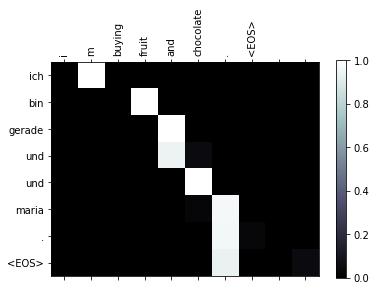

In [63]:

evaluateAndShowAttention("i m buying fruit and chocolate .")

In [65]:
for qitem in evaluate_queue:
    print( qitem[0] )    
    if isinstance(qitem[1],str):
        print( qitem[1] )
    elif isinstance(qitem[1],list):
        print( qitem[1] )    
    else:    
        nplist = qitem[1].flatten().detach().numpy()    
        if np.ndim( nplist ) == 0:
            print(nplist)
        else:
            print( nplist.flatten()[0:10] )

input_tensor
[  86   47  308 1121  785    4    1]
encoder_hidden
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
encoder_outputs
[-1.7593610e-01 -2.1630865e-01  9.4348907e-01  7.8240514e-02
 -3.7888288e-02  9.8887897e-01 -2.3685753e-02 -4.6230555e-03
 -1.6540289e-05 -2.6783466e-02]
input_tensor[ei]
[86]
encoder_hidden
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
encoder_output
[-1.7593610e-01 -2.1630865e-01  9.4348907e-01  7.8240514e-02
 -3.7888288e-02  9.8887897e-01 -2.3685753e-02 -4.6230555e-03
 -1.6540289e-05 -2.6783466e-02]
encoder_hidden
[-1.7593610e-01 -2.1630865e-01  9.4348907e-01  7.8240514e-02
 -3.7888288e-02  9.8887897e-01 -2.3685753e-02 -4.6230555e-03
 -1.6540289e-05 -2.6783466e-02]
encoder_outputs[ei]
[-1.7593610e-01 -2.1630865e-01  9.4348907e-01  7.8240514e-02
 -3.7888288e-02  9.8887897e-01 -2.3685753e-02 -4.6230555e-03
 -1.6540289e-05 -2.6783466e-02]
input_tensor[ei]
[47]
encoder_hidden
[-1.7593610e-01 -2.1630865e-01  9.4348907e-01  7.8240514e-02
 -3.7888288e-02  9.8887897e-01 -2.3685753e-02 -4.62305